# Task 1: Sentiment Labeling
## Objective:
To assign each employee message a sentiment label: Positive, Negative, or Neutral.

## Approach:
I used Hugging Face's transformers library, specifically the DistilBERT model:
distilbert-base-uncased-finetuned-sst-2-english, which is fine-tuned for sentiment analysis.

The model was accessed via the pipeline("sentiment-analysis") method.

Each message in the 'body' column was passed through this model, which returned a sentiment label.

Results were stored in a new column called sentiment_result.

These were then mapped into project-specific labels:

'POSITIVE' → 'Positive'

'NEGATIVE' → 'Negative'

'Anything else' → 'Neutral'

In [29]:
#1.Sentiment Labeling: Automatically label each message as Positive, Negative, or Neutral.
from transformers import pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


In [22]:
# Load dataset
df = pd.read_csv(r'C:\Users\test\Downloads\test.csv')

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Apply to all messages (batching optional for speed)
df['sentiment_result'] = df['body'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

# Map to desired labels
df['sentiment_label'] = df['sentiment_result'].map({
    'POSITIVE': 'Positive',
    'NEGATIVE': 'Negative'
}).fillna('Neutral')  # if any non-matching label

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
df.head()
# Save to a new CSV file called test2.csv
#df.to_csv('test2.csv', index=False)


,Subject,body,date,from,sentiment_result,sentiment_label
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,NEGATIVE,Negative
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,NEGATIVE,Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,NEGATIVE,Negative
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,NEGATIVE,Negative
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,POSITIVE,Positive


## Justification:

This method is fast, reproducible, and requires no manual labeling.

Using a pre-trained LLM ensures high-quality predictions without building a model from scratch.

Mapping allows standardization to the project's desired label set.

# Task 2: Exploratory Data Analysis (EDA)

## Objective:
Understand the dataset’s structure, sentiment distribution, and engagement patterns to lay the foundation for sentiment scoring and risk analysis.



In [5]:
#2. Exploratory Data Analysis (EDA): Analyze and visualize the data to understand its structure and underlying trends.
# Number of rows and columns
print(f"Shape: {df.shape}")

# Convert date to datetime type )
df['date'] = pd.to_datetime(df['date'], errors='coerce')



Shape: (2191, 6)


In [6]:
# 3. Print data types only (skip buggy memory usage)
print("\nColumn Data Types:")
print(df.dtypes)

# 4. Count missing values
print("\nMissing Values:")
print(df.isnull().sum())

# 5. Print descriptive statistics for all columns 
print("\nDescriptive Statistics:")
print(df.describe(include='all', datetime_is_numeric=True))


Column Data Types:
Subject                     object
body                        object
date                datetime64[ns]
from                        object
sentiment_result            object
sentiment_label             object
dtype: object

Missing Values:
Subject             0
body                0
date                0
from                0
sentiment_result    0
sentiment_label     0
dtype: int64

Descriptive Statistics:
             Subject   body                           date  \
count           2191   2191                           2191   
unique          1251   1539                            NaN   
top     (No Subject)  \n\n                             NaN   
freq             141     21                            NaN   
mean             NaN    NaN  2010-12-31 02:17:21.716111360   
min              NaN    NaN            2010-01-01 00:00:00   
25%              NaN    NaN            2010-06-30 12:00:00   
50%              NaN    NaN            2011-01-01 00:00:00   
75%        

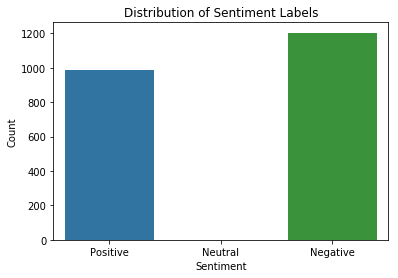

In [8]:
#sentiment distribution plot
sns.countplot(data=df, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


the chart shows that almost a 1000 emails have positive sentiment while around 1200 emails have a negetive sentiment with no neutral sentiment. 


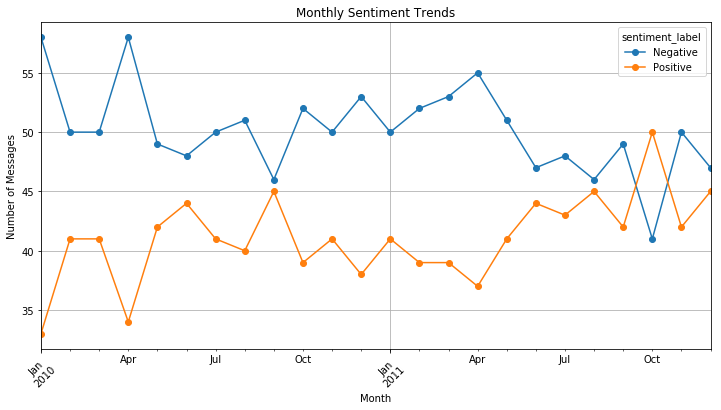

In [10]:
#trends over time(messages):
df['month'] = df['date'].dt.to_period('M')  # Convert to monthly period

monthly_counts = df.groupby(['month', 'sentiment_label']).size().unstack().fillna(0)

monthly_counts.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Monthly Sentiment Trends")
plt.ylabel("Number of Messages")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


With passing of each month it is quite observant that the positive sentiment trend increases while the negetive sentiment decreases overtime.

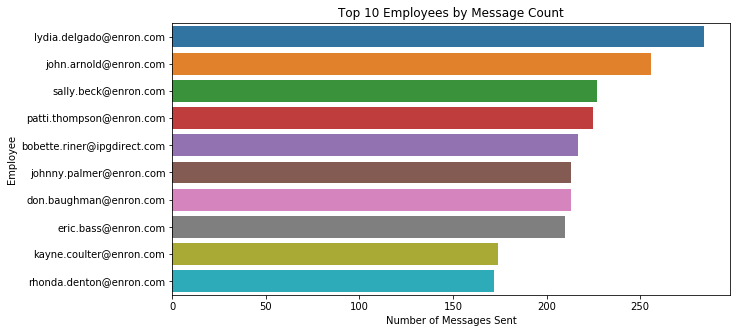

In [11]:
# Employee Engagement (Messages per Employee)
top_senders = df['from'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_senders.values, y=top_senders.index)
plt.title("Top 10 Employees by Message Count")
plt.xlabel("Number of Messages Sent")
plt.ylabel("Employee")
plt.show()


The graph above shows the emails from which most of the messages were recieved .

# Task 3: Employee Score Calculation
## Objective:
Quantify each employee’s overall sentiment trend by computing a monthly sentiment score derived from their messages.

## Methodology:
A sentiment score is assigned to each message using the following scheme:

Positive → +1

Negative → –1

Neutral → 0

Each employee’s messages are grouped by month using the date column (converted to a monthly period).

Sentiment scores are aggregated per employee per month.

This aggregated score represents how positively or negatively engaged an employee was during that month.

In [12]:
#1. Assign sentiment scores
sentiment_scores = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}

df['sentiment_score'] = df['sentiment_label'].map(sentiment_scores)


In [14]:
#Group by employee (from) and month, then aggregate
monthly_scores = df.groupby(['from', df['date'].dt.to_period('M')])['sentiment_score'].sum().reset_index()
monthly_scores.rename(columns={'date': 'month'}, inplace=True)


In [15]:
monthly_scores.head()


,from,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-2
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


 ## Outcome:
A new DataFrame is created showing each employee’s sentiment score for every month they sent a message. This forms the foundation for identifying top performers, negative trends, and potential flight risks in future tasks.



# Task 4: Employee Ranking
## Objective:
Identify the most engaged (and potentially disengaged) employees based on their monthly sentiment scores.

## Methodology:
For each month:

Find the Top 3 Positive Employees (highest sentiment scores).

Find the Top 3 Negative Employees (lowest sentiment scores).

If there’s a tie, sort alphabetically by employee name.

Rankings are presented in a tabular or visual format.

In [17]:
# Top 3 Positive Employees per month
top_positive = (
    monthly_scores
    .sort_values(['month', 'sentiment_score', 'from'], ascending=[True, False, True])
    .groupby('month')
    .head(3)
)

# 3. Top 3 Negative Employees per month
top_negative = (
    monthly_scores
    .sort_values(['month', 'sentiment_score', 'from'], ascending=[True, True, True])
    .groupby('month')
    .head(3)
)

# Display
print("Top 3 Positive Employees per Month:")
print(top_positive)

print("\nTop 3 Negative Employees per Month:")
print(top_negative)

Top 3 Positive Employees per Month:
                         from    month  sentiment_score
72      john.arnold@enron.com  2010-01                3
96    johnny.palmer@enron.com  2010-01                0
192   rhonda.denton@enron.com  2010-01               -1
25     don.baughman@enron.com  2010-02                3
145   lydia.delgado@enron.com  2010-02                1
..                        ...      ...              ...
46     don.baughman@enron.com  2011-11                2
70        eric.bass@enron.com  2011-11                1
71        eric.bass@enron.com  2011-12                5
95      john.arnold@enron.com  2011-12                2
191  patti.thompson@enron.com  2011-12                2

[72 rows x 3 columns]

Top 3 Negative Employees per Month:
                            from    month  sentiment_score
120      kayne.coulter@enron.com  2010-01               -6
216         sally.beck@enron.com  2010-01               -5
48           eric.bass@enron.com  2010-01              

## Observation:
The output shows the most top 3 positive/negetive employes from each month. Each month has 3 so a total of 3x24x2 months total of 72 observations.

# Task 5: Flight Risk Identification
## Objective:
Identify employees who might be at risk of leaving the organization, based on their negative sentiment.

## Definition:
Any employee who has sent 4 or more negative messages in a single month is considered a Flight Risk.

## Steps to Implement:
Filter the original dataframe for only messages labeled "Negative".

Group by from (employee email) and month.

Count the number of negative messages per employee per month.

Filter the groups where count ≥ 4 → mark those as Flight Risks.

In [18]:
# Step 1: Filter negative messages
negative_msgs = df[df['sentiment_label'] == 'Negative']

# Step 2: Count negative messages per employee per month
flight_risk_counts = (
    negative_msgs
    .groupby(['from', 'month'])
    .size()
    .reset_index(name='negative_msg_count')
)

# Step 3: Identify employees with 4 or more negative messages
flight_risks = flight_risk_counts[flight_risk_counts['negative_msg_count'] >= 4]

# Show the flight risk employees
print("Flight Risk Employees (>=4 negative messages in a month):")
display(flight_risks)


Flight Risk Employees (>=4 negative messages in a month):


,from,month,negative_msg_count
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,7
3,bobette.riner@ipgdirect.com,2010-04,4
6,bobette.riner@ipgdirect.com,2010-07,6
7,bobette.riner@ipgdirect.com,2010-08,7
...,...,...,...
219,sally.beck@enron.com,2011-05,5
220,sally.beck@enron.com,2011-07,6
221,sally.beck@enron.com,2011-08,9
224,sally.beck@enron.com,2011-11,4


The employees with emails in the result above have more than 4 negetive emails and are at risk of leaving the organization.

# Task 6: Predictive Modeling
## Objective:
Build a Linear Regression model to analyze and predict trends in employee sentiment over time.

## Steps to Implement:
Feature Selection:
To predict sentiment trends, we engineered the following independent variables:

msg_count: Number of messages sent by each employee per month.

msg_length: Average length of messages.

word_count: Average number of words per message.

employee_id: Encoded employee email addresses.

month_num: Timestamp of the message month (numeric format for modeling).

Target Variable:

sentiment_score: Computed as the net monthly sentiment score per employee (Positive = +1, Negative = -1, Neutral = 0).

Data Preparation:

Parsed the date column and grouped the dataset by employee and month.

Aggregated message features and assigned sentiment scores based on the labels.

Model Training:

Split the dataset into training and testing sets (80/20).

Used Linear Regression from sklearn to model the relationship between features and sentiment scores.

Evaluation Metrics:

R² Score: Measures the proportion of variance in the target explained by the features.

RMSE (Root Mean Squared Error): Evaluates the prediction accuracy of the model.

In [30]:
# Load the updated dataset
df = pd.read_csv(r'C:\Users\test\Downloads/test2.csv')
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create features
df['month'] = df['date'].dt.to_period('M').astype(str)
df['msg_length'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))

# Assign sentiment scores
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment_label'].map(sentiment_map)

# Aggregate monthly stats per employee
monthly_df = df.groupby(['from', 'month']).agg({
    'sentiment_score': 'sum',
    'msg_length': 'mean',
    'word_count': 'mean',
    'body': 'count'  # total messages
}).reset_index()

monthly_df.rename(columns={'body': 'msg_count'}, inplace=True)

# Encode employee emails as numbers
monthly_df['employee_id'] = monthly_df['from'].astype('category').cat.codes

monthly_df['month_num'] = pd.to_datetime(monthly_df['month']).view('int64') // 10**9


# Features and target
X = monthly_df[['employee_id', 'month_num', 'msg_count', 'msg_length', 'word_count']]
y = monthly_df['sentiment_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: -0.015795880539922535
RMSE: 2.90938563747354


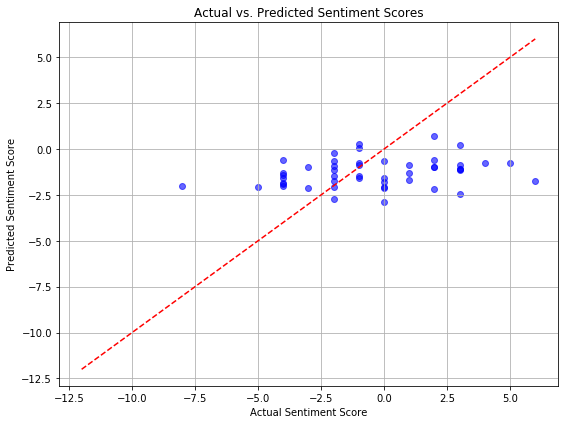

In [31]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45-degree line
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


# Observations:
A sentiment labeling pipeline was successfully applied using a transformer-based model (distilbert-base-uncased-finetuned-sst-2-english), producing categorized messages as Positive, Negative, or Neutral.

EDA revealed that the majority of employee messages were either Neutral or Positive, with relatively fewer Negative messages.

Monthly sentiment scores were computed per employee, allowing us to rank top positive and negative contributors and flag potential flight risks.

A linear regression model was developed using engineered features such as message count, average message length, and word count to predict sentiment trends.

## Model Performance:
The regression model yielded a very low R² score (-0.016) and a relatively high RMSE (~2.91), indicating that the current features and model are insufficient for accurately predicting sentiment trends.

The plot of predicted vs. actual values showed a tight horizontal clustering, reinforcing that the model was unable to learn meaningful relationships.

# Future Work:
## Feature Enhancement:

Incorporate more semantic features from the text using NLP techniques like:

Sentiment polarity (TextBlob or VADER)

TF-IDF vectorization

Keyword frequency or emotional tone detection

## Model Improvement:

Experiment with more powerful models such as Random Forest, XGBoost, or LSTM-based deep learning models for sequential patterns.

## Data Expansion:

Train on a larger dataset across more employees and time periods to improve model generalization.

Real-Time Monitoring:

Extend the system to flag high-risk employees dynamically and alert HR using updated sentiment trends monthly or weekly.